# Melody generation using LSTM  
#### *DEBRAY Clarisse - clarisse.debray@student-cs.fr*
## Imports

In [18]:
import pandas as pd
from music21 import converter, note, stream, chord
import itertools
import warnings
import random
import numpy as np
import ast
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import ast
import matplotlib.pyplot as plt
from collections import Counter
import joblib

warnings.filterwarnings("ignore")

In [3]:
#import de la table
path = 'data\maestro-v3.0.0.csv'
df = pd.read_csv(path)

## Exploration  
Affichage d'un morceau

In [3]:
#Affichage d'un morceau
morceau = random.randint(0,df.shape[0])
midi = converter.parse('data/'+df['midi_filename'].to_list()[morceau])
midi.show('midi')

Visualisation des notes du morceau précédent sur 30 secondes

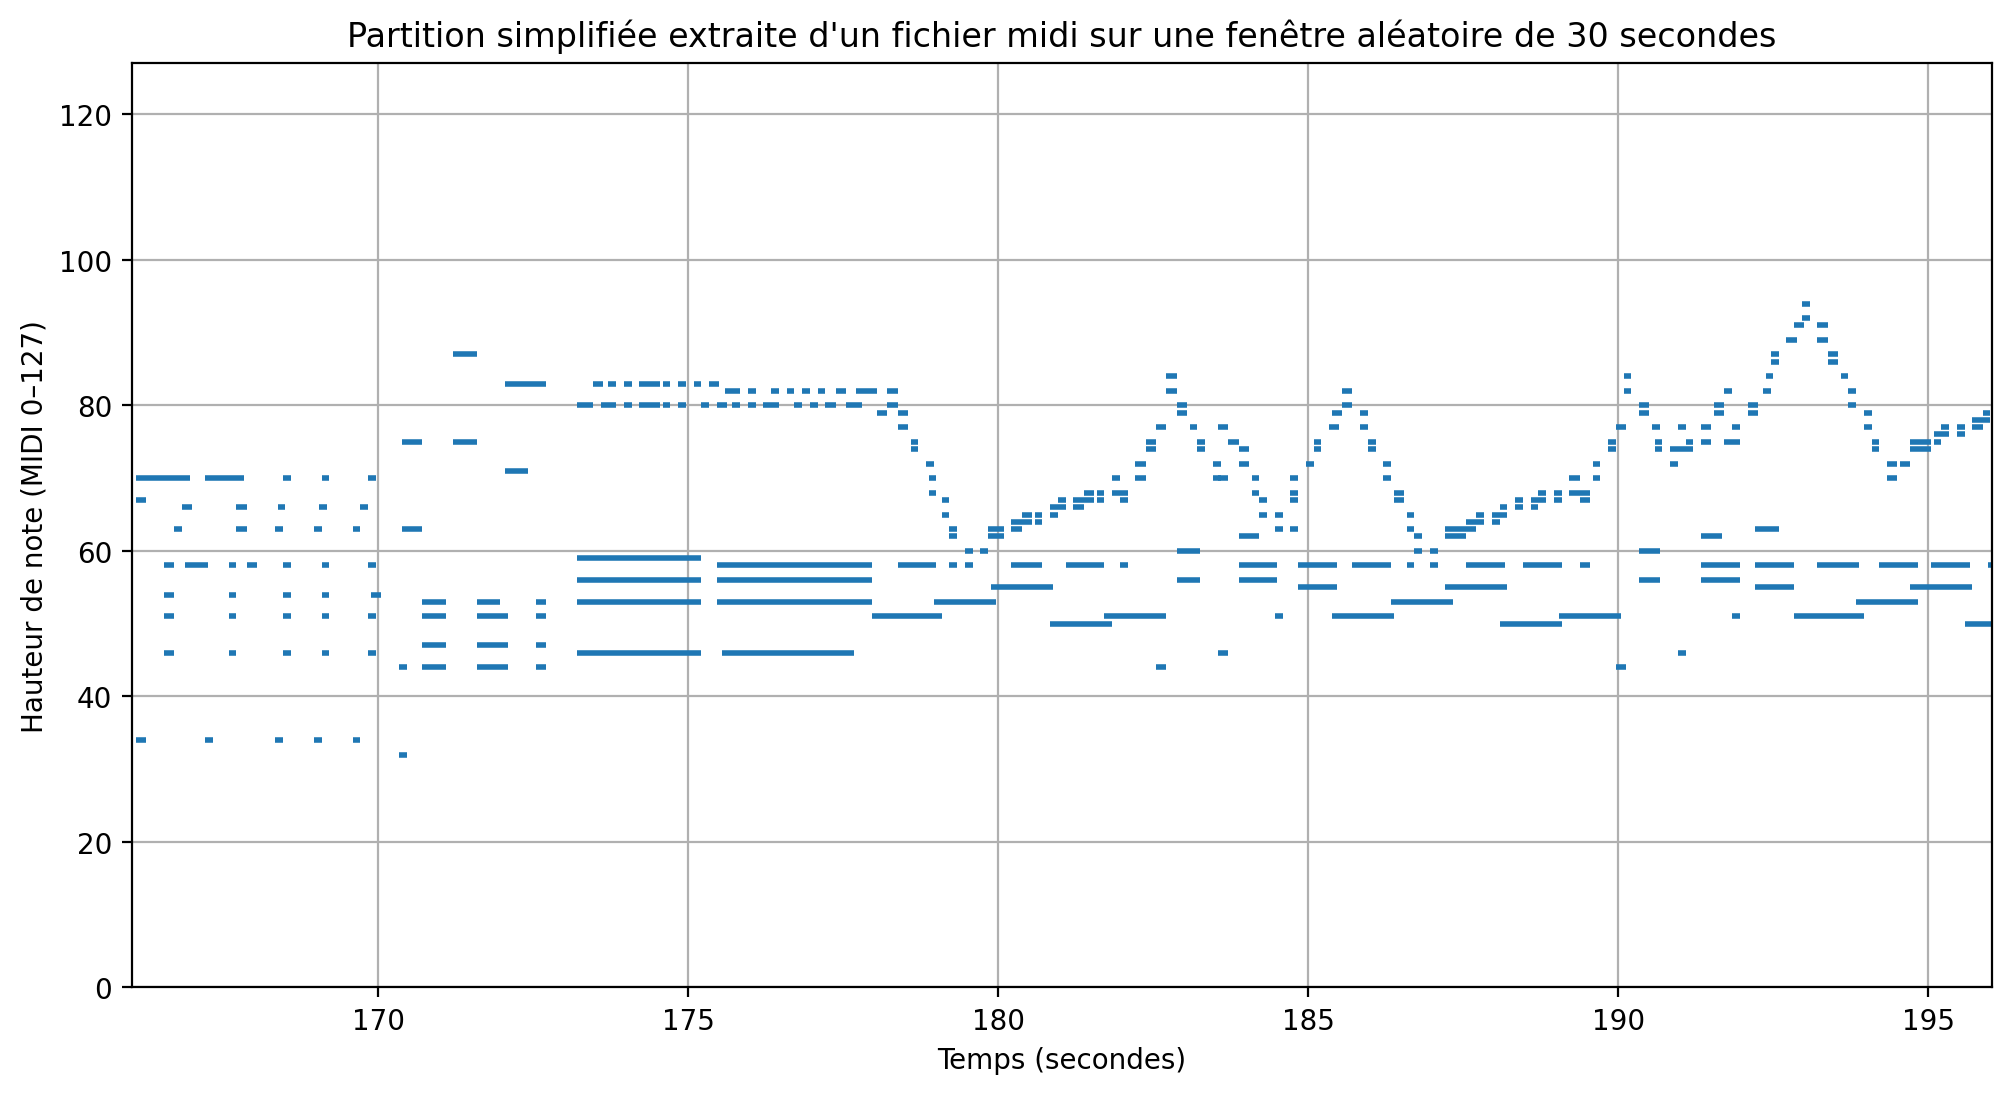

In [4]:
# Extraire le tempo (en microsecondes par noire) → convertir en BPM
tempo_indication = midi.metronomeMarkBoundaries()[0][2]
bpm = tempo_indication.number
seconds_per_quarter = 60 / bpm

# Créer la liste de toutes les notes avec leurs temps
note_list = []
for part in midi.parts:
    flat_part = part.flat.notes
    for element in flat_part:
        start_ql = float(element.offset)
        dur_ql = float(element.quarterLength)
        start_sec = start_ql * seconds_per_quarter
        duration_sec = dur_ql * seconds_per_quarter

        if isinstance(element, note.Note):
            note_list.append({
                'pitch': element.pitch.midi,
                'start': start_sec,
                'duration': duration_sec
            })
        elif isinstance(element, chord.Chord):
            for pitch in element.pitches:
                note_list.append({
                    'pitch': pitch.midi,
                    'start': start_sec,
                    'duration': duration_sec
                })

#Pour que ce soit lisible, je ne visualise que 30 secondes
total_duration = max(n['start'] + n['duration'] for n in note_list)
window_duration = 30

#On choisit un point de départ aléatoire
start_time = random.uniform(0, total_duration - window_duration)
end_time = start_time + window_duration
window_notes = [n for n in note_list if start_time <= n['start'] <= end_time] #on en sélectionne que les notes dans la fenetre

# Affichage
fig, ax = plt.subplots(figsize=(12, 6))
for n in window_notes:
    ax.hlines(y=n['pitch'], xmin=n['start'], xmax=n['start'] + n['duration'], linewidth=2)

ax.set_xlabel("Temps (secondes)")
ax.set_ylabel("Hauteur de note (MIDI 0–127)")
ax.set_title(f"Partition simplifiée extraite d'un fichier midi sur une fenêtre aléatoire de 30 secondes")
ax.set_ylim(0, 127)
ax.set_xlim(start_time, end_time)
ax.grid(True)
plt.show()

Répartition des notes sur tous les fichiers midi de la base

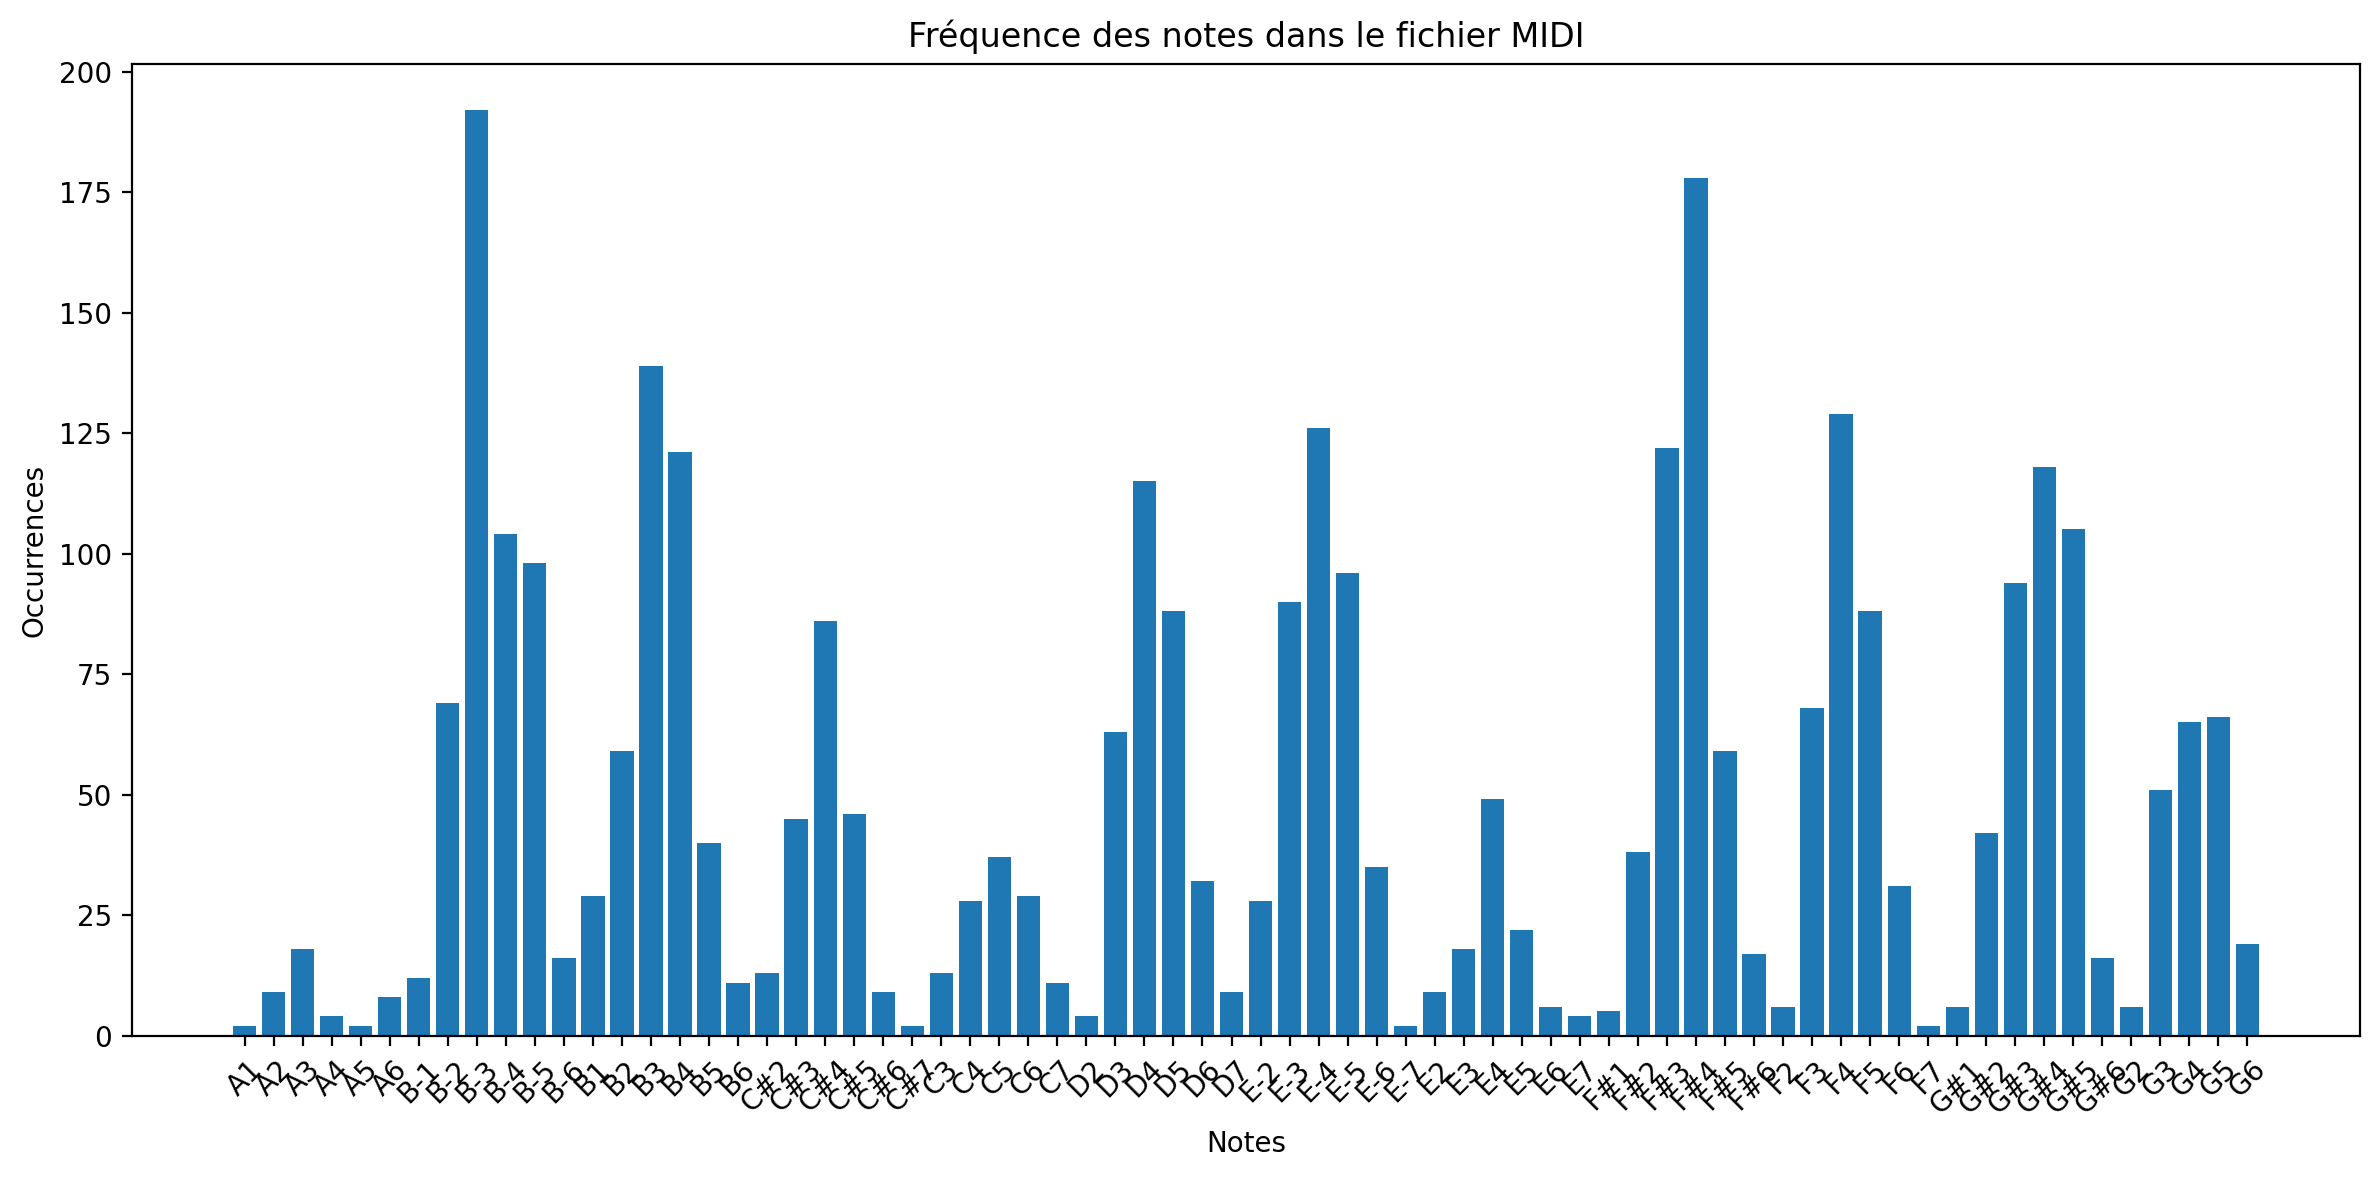

In [5]:
# Extraire les notes d'un fichier MIDI
def extraire_notes(midi_path):
    notes = []
    try:
        score = converter.parse(midi_path)
        for element in score.recurse():
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                for n in element.notes:
                    notes.append(str(n.pitch))
    except Exception as e:
        print(f"Erreur avec {midi_path} : {e}")
    return notes

# Exemple : récupérer le nom du fichier via ton DataFrame et l'index "morceau"
midi_path = 'data/' + df['midi_filename'].to_list()[morceau]
notes_du_fichier = extraire_notes(midi_path)

# Compter les occurrences des notes
compteur_notes = Counter(notes_du_fichier)

# Trier les notes par nom (ex : C4, D#5, etc.)
notes_ordonnees = sorted(compteur_notes.items(), key=lambda x: x[0])

# Séparer noms et fréquences
noms_notes, frequences = zip(*notes_ordonnees)

# Afficher le diagramme en barres
plt.figure(figsize=(12, 6))
plt.bar(noms_notes, frequences)
plt.title("Fréquence des notes dans le fichier MIDI")
plt.xlabel("Notes")
plt.ylabel("Occurrences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Extraction et preprocessing

In [4]:
#On sélectionne les auteurs avec au moins une musique label en tant que train, test et val
df_i = df.groupby(['canonical_composer','split'])['midi_filename'].count().reset_index().sort_values(by='canonical_composer')
df_i = df_i.reset_index().groupby('canonical_composer')['index'].count().reset_index()
comp = df_i[df_i['index']==3]['canonical_composer'].to_list()
df = df[df['canonical_composer'].isin(comp)]

#Si on reduit l'étude à un ou plusieurs auteurs (par soucis de temps de calcul tout en conservant une similarité dans les styles)
df_i = df.groupby('canonical_composer')['midi_filename'].count().reset_index().sort_values(by='midi_filename')
comp = df_i['canonical_composer'].to_list()[0:3] #Sélection du nombre d'auteurs : les premiers ont moins de musiques et inversement
df = df[df['canonical_composer'].isin(comp)]

In [5]:
def extraction_notes(file):
    '''
    Fonction pour extraires les notes d'un fichiers midi dans une liste
    avec les éléments int compris entre 0 et 127 
    Pour les accords on ne prend que la note la plus haute (la plus aigue)
    '''
    midi = converter.parse(file)
    L_notes = []
    for e in midi.recurse().notes:
        if e.isNote:
            N = e.pitch.midi
            L_notes.append(N)
        elif e.isChord:
            accords = [n.midi for n in e.pitches]
            N = max(accords)
            L_notes.append(N)
    if len(L_notes)<8:
        return 'null'
    else:
        return L_notes 
    
def ex_notes_tab(df,col_out):
    '''
    Création de la colonne contenant la liste des notes
    '''
    df['midi_file_data'] = 'data/'+df['midi_filename']
    df[col_out] = df['midi_file_data'].apply(extraction_notes)
    return df[df[col_out]!='null']


def sequence_list(L):
    ''' création des séquences de 50 notes et output cette liste et de la note suivante (cible)'''
    sequence_length = 50

    input_sequences = []
    output_notes = []

    for i in range(len(L) - sequence_length):
        seq_in = L[i:i + sequence_length]  
        seq_out = L[i + sequence_length]  
        input_sequences.append(seq_in)
        output_notes.append(seq_out)

    return input_sequences,output_notes

def sequence(dff):
    ''' 
    Application du séquencage à toutes les musiques
    '''
    X,y = [],[]
    for k in dff['notes'].to_list():
        xtemp,ytemp = sequence_list(k)
        X.append(xtemp)
        y.append(ytemp)
    X=list(itertools.chain(*X))
    y=list(itertools.chain(*y))

    return pd.DataFrame({"X":X,"y":y})

def colonnes(df):
    ''' mise en forme : 1 temps = 1 colonne = 1 note '''
    df_expanded = df['X'].apply(pd.Series)
    df_expanded['y'] = df['y']
    return df_expanded

def preprocessing(df):
    ''' application de toutes les fonctions de preprocessing '''
    dftrain = colonnes(sequence(ex_notes_tab(df[df['split']=='train'],'notes')))
    dftest = colonnes(sequence(ex_notes_tab(df[df['split']=='test'],'notes')))
    dfval = colonnes(sequence(ex_notes_tab(df[df['split']=='validation'],'notes')))

    return dftrain,dftest,dfval

dftrain,dftest,dfval = preprocessing(df)

## Modélisation

In [19]:
def df_to_tensor(df,num_classes=128):
    ''' mise en forme sous tenseurs avec les notes en tant que catégories '''
    col = [i for i in df.columns if i!='y']
    X_raw = df[col].values.astype(int)
    X = to_categorical(X_raw, num_classes=num_classes)
    y_raw = df["y"].astype(int).values
    y = to_categorical(y_raw, num_classes=num_classes)
    return X, y


X_train, y_train = df_to_tensor(pd.DataFrame(dftrain))
X_val, y_val = df_to_tensor(pd.DataFrame(dfval))
X_test, y_test = df_to_tensor(pd.DataFrame(dftest))

#Définition du modèle
sequence_length = 50
num_notes = 128

model = Sequential()
model.add(LSTM(256, input_shape=(sequence_length, num_notes), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(num_notes))
model.add(Activation('softmax'))

optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model.summary()

#Entrainement
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,448 (3.63 MB)

 Trainable params: 952,448 (3.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
6169/6169 ━━━━━━━━━━━━━━━━━━━━ 445s 72ms/step - loss: 3.6201 - val_loss: 3.6345
Epoch 2/200
6169/6169 ━━━━━━━━━━━━━━━━━━━━ 483s 78ms/step - loss: 3.3360 - val_loss: 3.6499
Epoch 3/200
3625/6169 ━━━━━━━━━━━━━━━━━━━━ 3:03 72ms/step - loss: 3.2333

KeyboardInterrupt: 

In [ ]:
#Enregistrement du model
joblib.dump(model, 'modele_generation_melodie_midi.pkl')

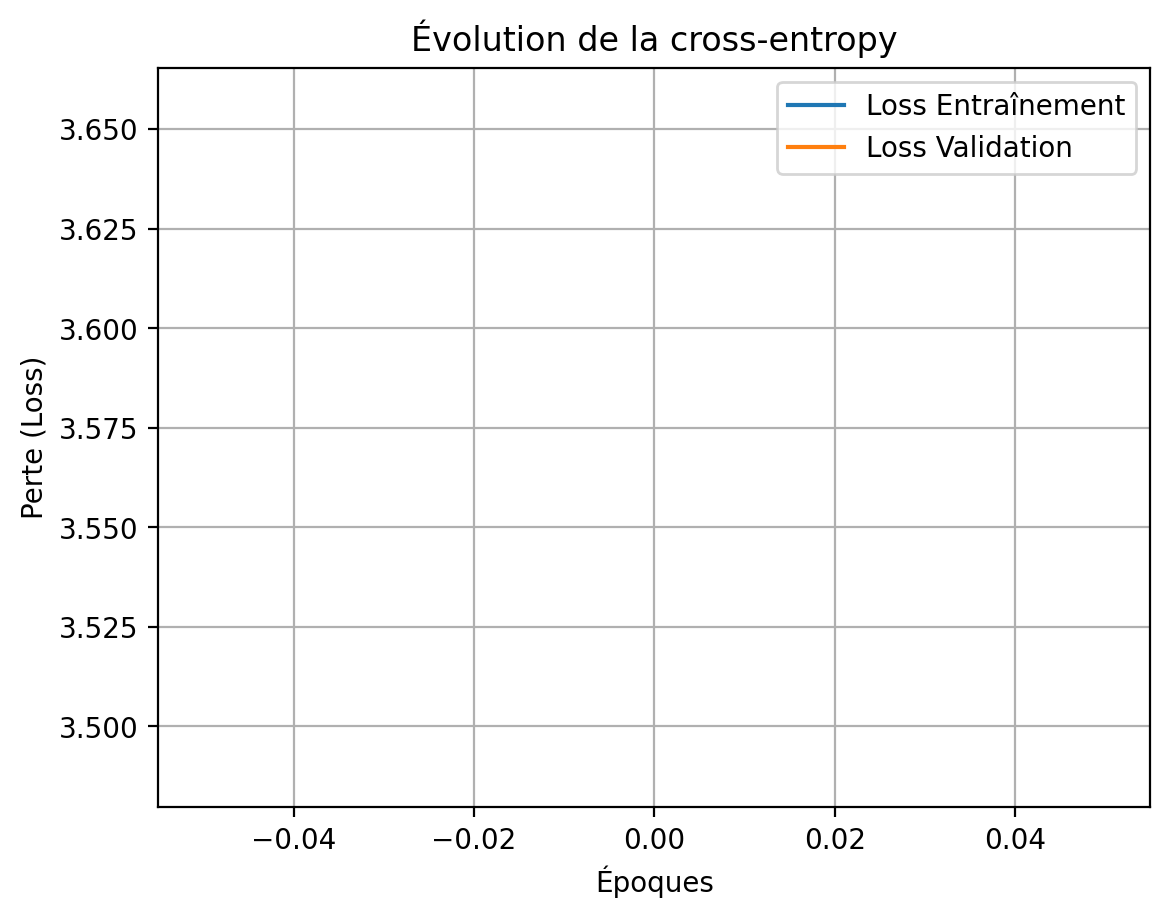

In [ ]:
#Visualisation cross entropy selon les époques
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, label='Loss Entraînement')
plt.plot(val_loss, label='Loss Validation')
plt.title('Évolution de la cross-entropy')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.grid(True)
plt.show()

## Génération séquences

In [ ]:
def generate_sequence(model, seed_sequence, length=50, noise_std=0.0, num_classes=128):
    '''fonction qui permet de générer une séquence de 100 notes après l'apprentissage du modèle '''
    generated = list(seed_sequence)

    for _ in range(length):
        
        input_seq_raw = generated[-50:]
        input_seq = to_categorical(input_seq_raw, num_classes=num_classes).reshape(1, 50, num_classes)

        # Prédiction
        pred_distribution = model.predict(input_seq, verbose=0)[0] 
        
        #Ajout de bruit
        if noise_std > 0.0:
            pred_distribution += np.random.normal(0, noise_std, size=pred_distribution.shape)
        
        #Note la plus probable
        next_val = int(np.argmax(pred_distribution))
        generated.append(next_val)

    return generated

ligne_seed = random.randint(0,dftest.shape[0]-1) #Choix aléatoire de la seed dans l'ensemble de test
seed_sequence = dftest.iloc[ligne_seed, :50].astype(int).tolist()
generated = generate_sequence(model, seed_sequence=seed_sequence, length=100, noise_std=2.0) #génération d'une séquence de 100 notes

def applatissement(generated):
    ''' fonction qui permet "d'applatir" les notes à des 
    octaves plus raisonnables sans changer les notes pour 
    mieux rendre à l'oreille '''
    generated2 = []
    for k in range(len(generated)):
        n = generated[k]
        if k == 0:
            generated2.append(n)
        else:
            while n < 48: #note minimale pour une mélodie
                n+=12 #un octave en plus
            while n > 80: #note max mélodie
                n-=12 #un octave en moins
            generated2.append(n)
    return generated2

generated2 = applatissement(generated)


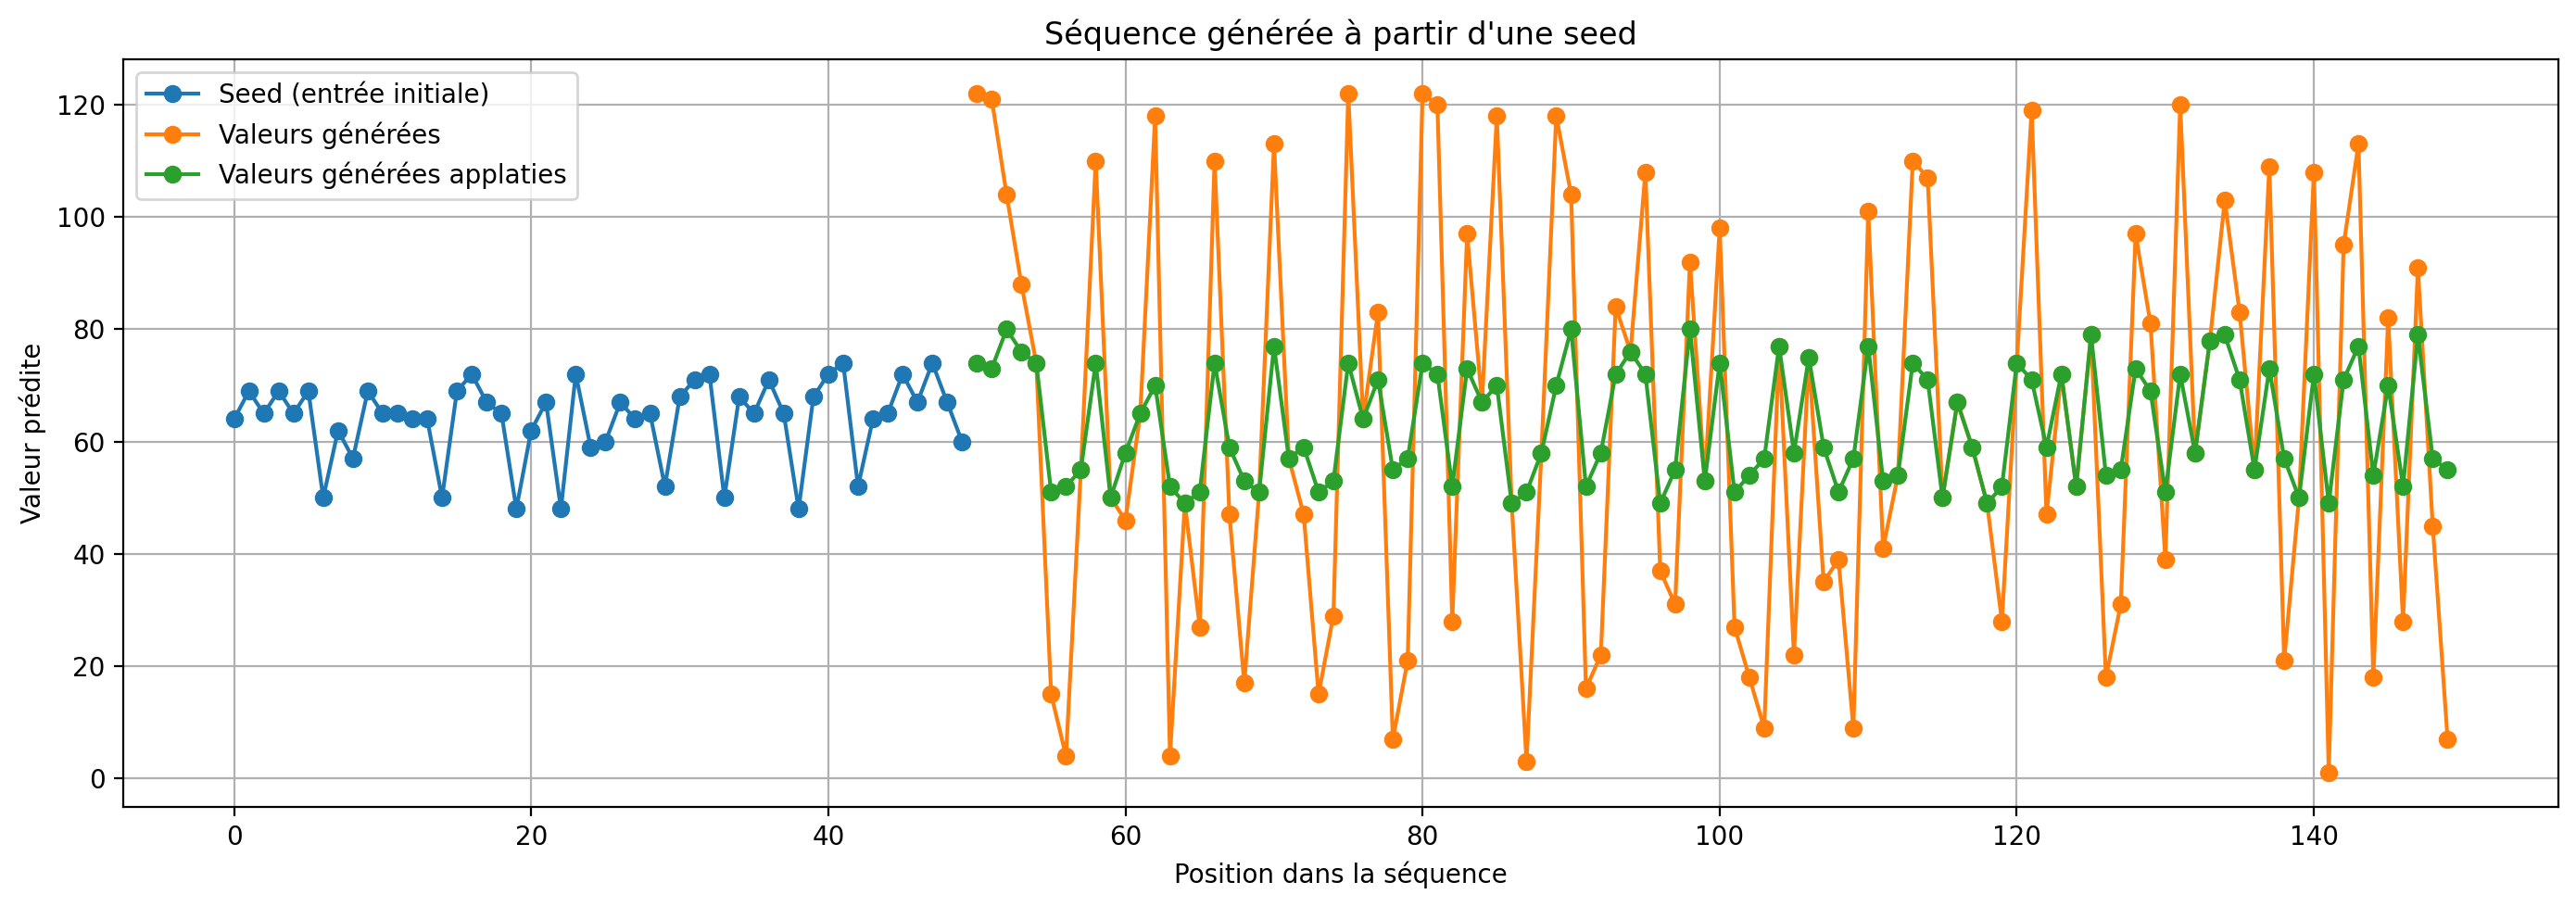

In [ ]:
#Visualisation de la génération
plt.figure(figsize=(14, 5))
plt.plot(range(len(seed_sequence)), seed_sequence, label='Seed (entrée initiale)', marker='o')
plt.plot(range(len(seed_sequence), len(generated)), generated[len(seed_sequence):], label='Valeurs générées', marker='o')
plt.plot(range(len(seed_sequence), len(generated2)), generated2[len(seed_sequence):], label='Valeurs générées applaties', marker='o')
plt.title("Séquence générée à partir d'une seed")
plt.xlabel("Position dans la séquence")
plt.ylabel("Valeur prédite")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Affichage du résultat non applati
s = stream.Stream()
duration = 0.5  # durée en quarts de note pour les notes générées

for e in generated[51:]:
    e = note.Note(e)
    e.quarterLength = duration
    s.append(e)

s.show('midi')

In [ ]:
#Affichage du résultat applati
s = stream.Stream()
duration = 0.5 

for e in generated2[51:]:
    e = note.Note(e)
    e.quarterLength = duration
    s.append(e)


s.show('midi')